In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns
import glob

def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

In [ ]:
image_dir = Path('/content/drive/MyDrive/skin_cancer/Augmented')
filepaths = list(image_dir.glob(r'**/*.jpeg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,/content/drive/MyDrive/skin_cancer/Augmented/N...,NonCancer
1,/content/drive/MyDrive/skin_cancer/Augmented/N...,NonCancer
2,/content/drive/MyDrive/skin_cancer/Augmented/C...,Cancer


Visualization

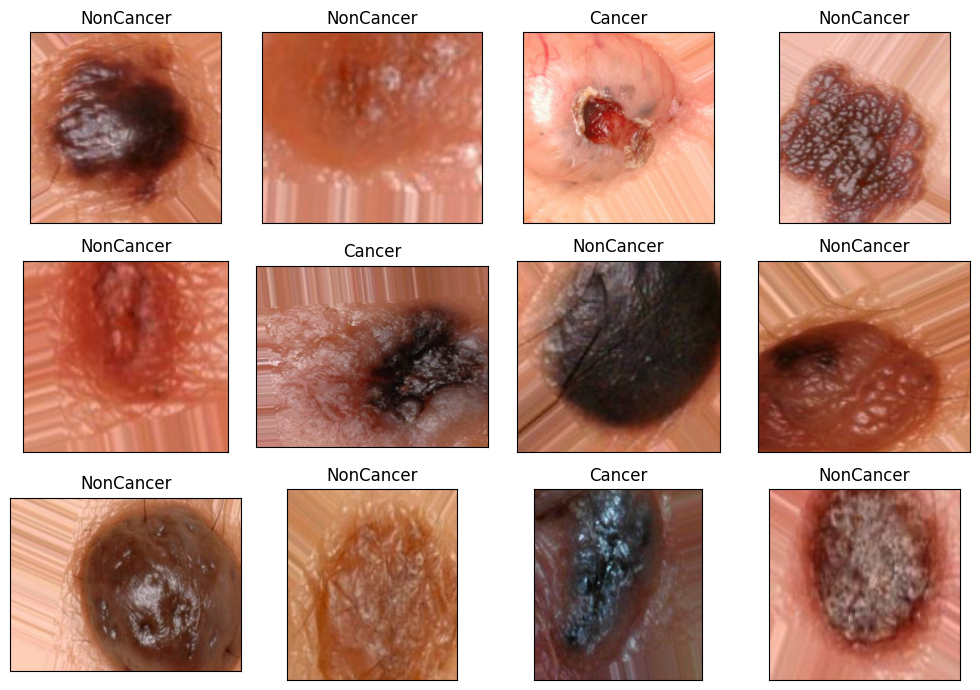

In [ ]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [ ]:
vc = image_df['Label'].value_counts()
print(vc)

NonCancer    1972
Cancer        890
Name: Label, dtype: int64


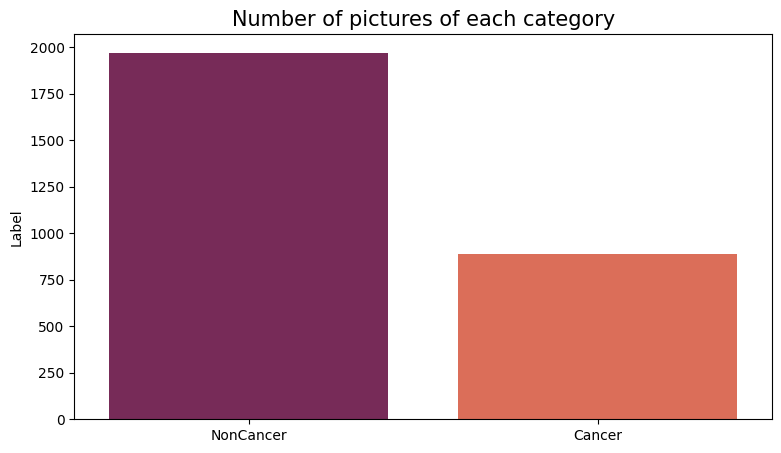

In [ ]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(256, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

Found 2575 validated image filenames belonging to 2 classes.
Found 2575 validated image filenames belonging to 2 classes.
Found 287 validated image filenames belonging to 2 classes.






58889256/58889256 [==============================] - 0s 0us/step
VGG16 Model Training Started ===>>>
Epoch 1/20
81/81 [==============================] - 631s 8s/step - loss: 0.4827 - accuracy: 0.7748 - val_loss: 0.4510 - val_accuracy: 0.7748
Epoch 2/20
81/81 [==============================] - 30s 367ms/step - loss: 0.3257 - accuracy: 0.8614 - val_loss: 0.2751 - val_accuracy: 0.8769
Epoch 3/20
81/81 [==============================] - 36s 441ms/step - loss: 0.2462 - accuracy: 0.8983 - val_loss: 0.2022 - val_accuracy: 0.9216
Epoch 4/20
81/81 [==============================] - 29s 365ms/step - loss: 0.1902 - accuracy: 0.9301 - val_loss: 0.1792 - val_accuracy: 0.9285
Epoch 5/20
81/81 [==============================] - 29s 361ms/step - loss: 0.1776 - accuracy: 0.9278 - val_loss: 0.1360 - val_accuracy: 0.949

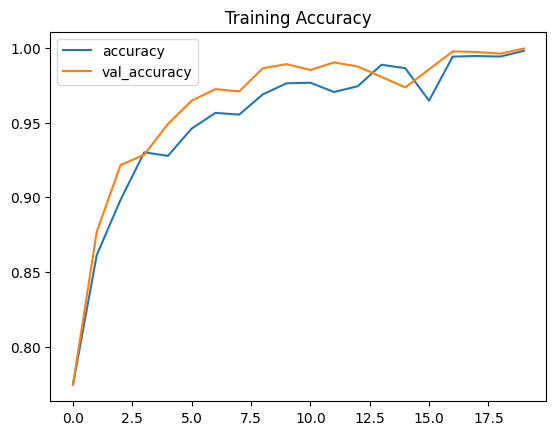

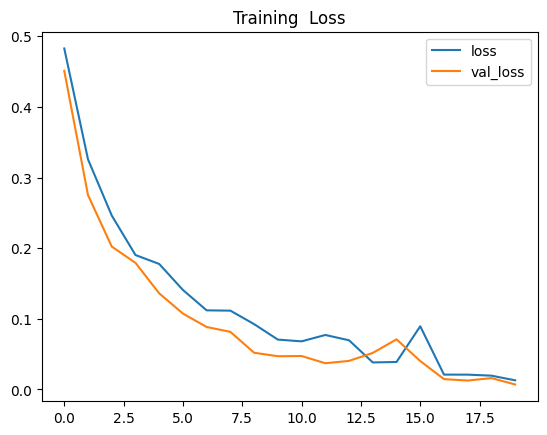



Accuracy on the test set: 96.52%
9/9 [==============================] - 2s 169ms/step
Accuracy: 0.96516
Precision: 0.96688
Recall: 0.96516
F1 Score: 0.96463
              precision    recall  f1-score   support

      Cancer       1.00      0.89      0.94        95
   NonCancer       0.95      1.00      0.97       192

    accuracy                           0.97       287
   macro avg       0.98      0.95      0.96       287
weighted avg       0.97      0.97      0.96       287

VGG16 Confusion Matrix: 




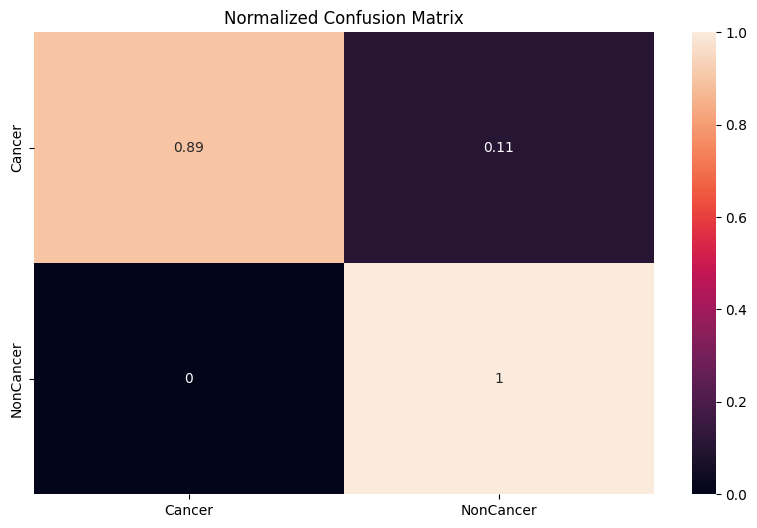

Performance: 

Rec=    94.73684210526316
Spe=    99.9815973500184
Pre=    95.23809523809524
FPR=    0.01840264998159733
FNR=    5.263157894736842
NPV=    99.98160412067698
FDR=    4.7619047619047565




171446536/171446536 [==============================] - 1s 0us/step
ResNet101 Model Training Started ===>>>
Epoch 1/20
81/81 [==============================] - 49s 497ms/step - loss: 0.6398 - accuracy: 0.6874 - val_loss: 0.6030 - val_accuracy: 0.7021
Epoch 2/20
81/81 [==============================] - 32s 401ms/step - loss: 0.5953 - accuracy: 0.6986 - val_loss: 0.5879 - val_accuracy: 0.7181
Epoch 3/20
81/81 [==============================] - 37s 458ms/step - loss: 0.5880 - accuracy: 0.7184 - val_loss: 0.5919 - val_accuracy: 0.7021
Epoch 4/20
81/81 [==============================] - 33s 402ms/step - loss: 0.5808 - accuracy: 0.7161 - val_loss: 0.5685 - val_accuracy: 0.7282
Epoch 5/20
81/81 [==============================] - 33s 410ms/step - loss: 0.5763 - accuracy: 0.7208 - val_loss: 0.551

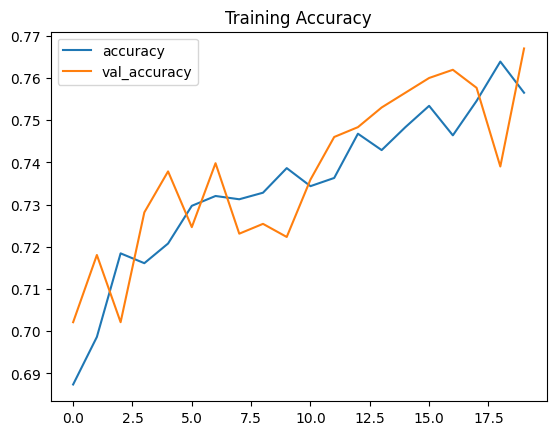

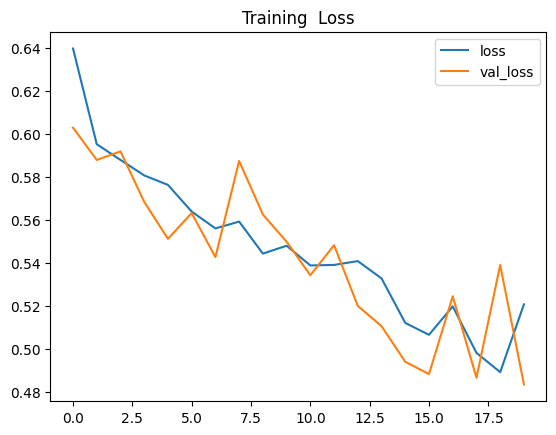



Accuracy on the test set: 75.61%
9/9 [==============================] - 3s 194ms/step
Accuracy: 0.7561
Precision: 0.75405
Recall: 0.7561
F1 Score: 0.73188
              precision    recall  f1-score   support

      Cancer       0.75      0.40      0.52        95
   NonCancer       0.76      0.93      0.84       192

    accuracy                           0.76       287
   macro avg       0.75      0.67      0.68       287
weighted avg       0.75      0.76      0.73       287

ResNet101 Confusion Matrix: 




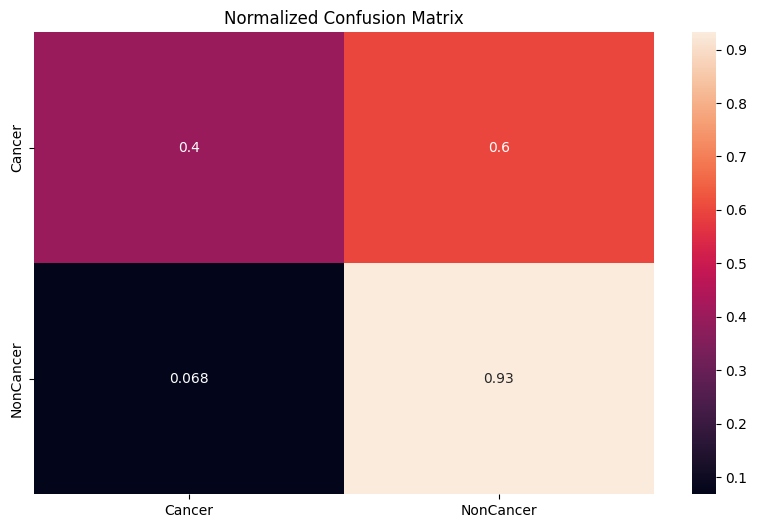

Performance: 

Rec=    66.61458333333333
Spe=    99.88326777389278
Pre=    73.18317463537826
FPR=    0.1167322261072261
FNR=    33.385416666666664
NPV=    99.8834405659073
FDR=    26.81682536462173




74836368/74836368 [==============================] - 0s 0us/step
DenseNet201 Model Training Started ===>>>
Epoch 1/20
81/81 [==============================] - 51s 447ms/step - loss: 0.2436 - accuracy: 0.9025 - val_loss: 0.0809 - val_accuracy: 0.9748
Epoch 2/20
81/81 [==============================] - 30s 376ms/step - loss: 0.0722 - accuracy: 0.9783 - val_loss: 0.0350 - val_accuracy: 0.9899
Epoch 3/20
81/81 [==============================] - 30s 376ms/step - loss: 0.0461 - accuracy: 0.9810 - val_loss: 0.0301 - val_accuracy: 0.9880
Epoch 4/20
81/81 [==============================] - 30s 369ms/step - loss: 0.0168 - accuracy: 0.9946 - val_loss: 0.0153 - val_accuracy: 0.9934
Epoch 5/20
81/81 [==============================] - 31s 380ms/step - loss: 0.0281 - accuracy: 0.9887 - val_loss: 0.0186

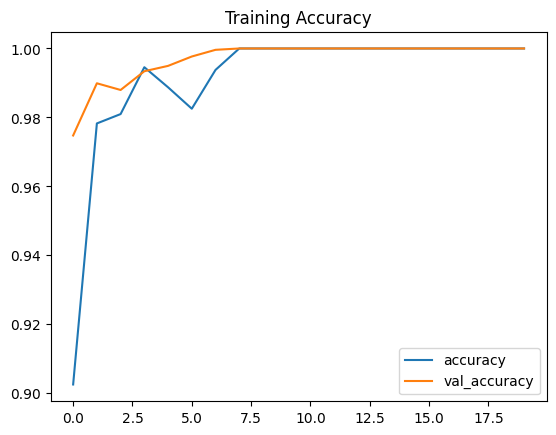

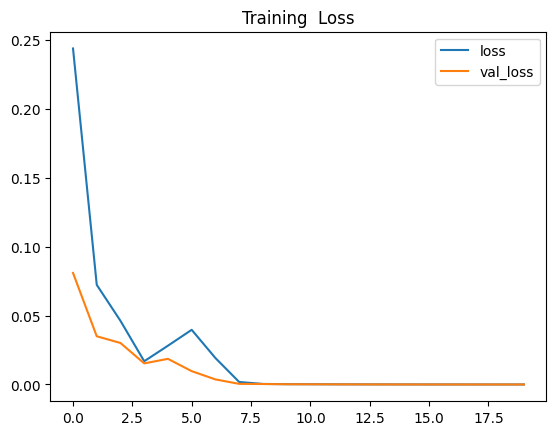



Accuracy on the test set: 98.95%
9/9 [==============================] - 4s 183ms/step
Accuracy: 0.98955
Precision: 0.9896
Recall: 0.98955
F1 Score: 0.98956
              precision    recall  f1-score   support

      Cancer       0.98      0.99      0.98        95
   NonCancer       0.99      0.99      0.99       192

    accuracy                           0.99       287
   macro avg       0.99      0.99      0.99       287
weighted avg       0.99      0.99      0.99       287

DenseNet201 Confusion Matrix: 




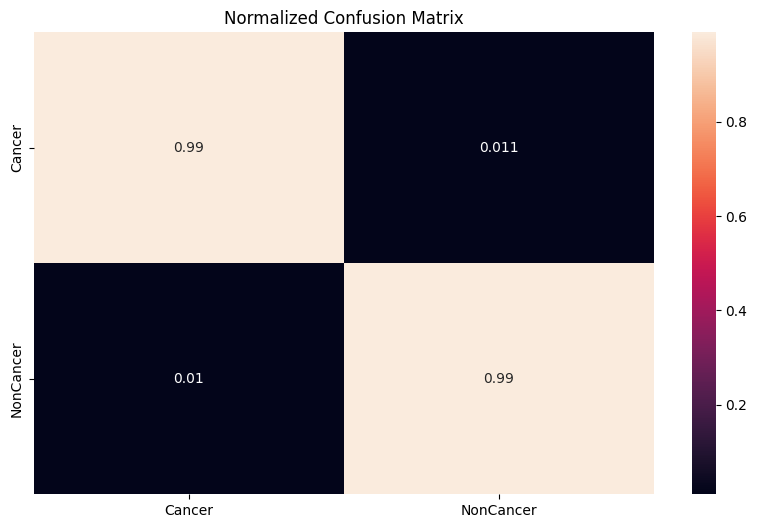

Performance: 

Rec=    98.95285087719299
Spe=    99.99633863943073
Pre=    98.9528514657497
FPR=    0.003661360569255286
FNR=    1.0471491228070173
NPV=    99.9963386394381
FDR=    1.0471485342502989




87910968/87910968 [==============================] - 0s 0us/step
InceptionV3 Model Training Started ===>>>
Epoch 1/20
81/81 [==============================] - 36s 367ms/step - loss: 0.4160 - accuracy: 0.8295 - val_loss: 0.2084 - val_accuracy: 0.9068
Epoch 2/20
81/81 [==============================] - 27s 331ms/step - loss: 0.1832 - accuracy: 0.9192 - val_loss: 0.1307 - val_accuracy: 0.9499
Epoch 3/20
81/81 [==============================] - 34s 425ms/step - loss: 0.1435 - accuracy: 0.9425 - val_loss: 0.0806 - val_accuracy: 0.9685
Epoch 4/20
81/81 [==============================] - 27s 334ms/step - loss: 0.1337 - accuracy: 0.9452 - val_loss: 0.0802 - val_accuracy: 0.9701
Epoch 5/20
81/81 [==============================] - 27s 333ms/step - loss: 0.0789 - accuracy: 0.9674 - val_loss: 0.04

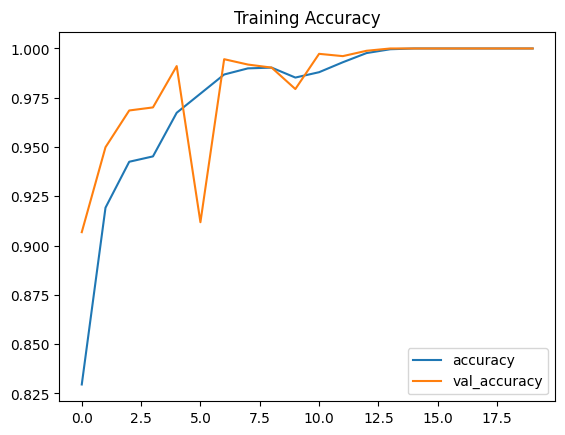

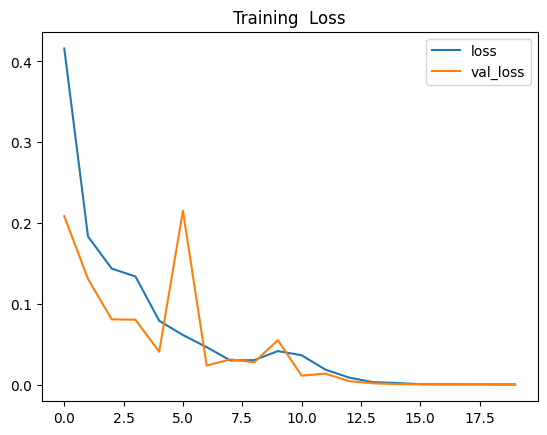



Accuracy on the test set: 97.21%
9/9 [==============================] - 3s 162ms/step
Accuracy: 0.97213
Precision: 0.97237
Recall: 0.97213
F1 Score: 0.9722
              precision    recall  f1-score   support

      Cancer       0.95      0.97      0.96        95
   NonCancer       0.98      0.97      0.98       192

    accuracy                           0.97       287
   macro avg       0.97      0.97      0.97       287
weighted avg       0.97      0.97      0.97       287

InceptionV3 Confusion Matrix: 




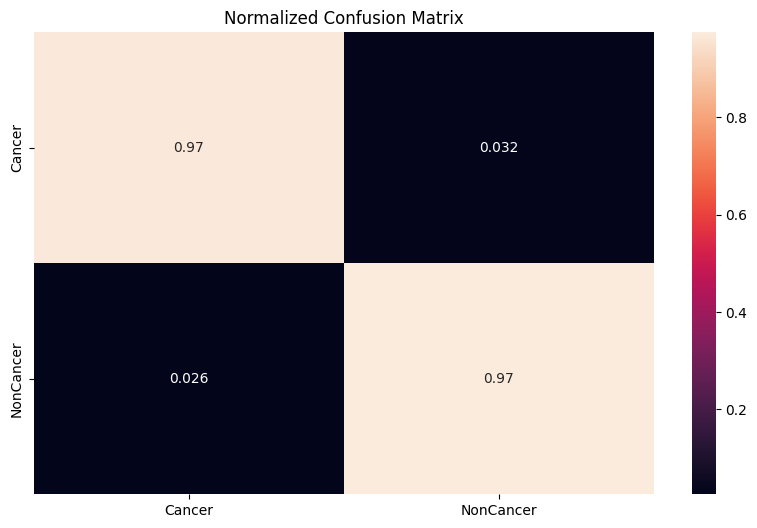

Performance: 

Rec=    97.11896929824562
Spe=    99.98992646607778
Pre=    97.12041407976501
FPR=    0.010073533922218124
FNR=    2.8810307017543835
NPV=    99.98992648481665
FDR=    2.8795859202349865




219055592/219055592 [==============================] - 1s 0us/step
InceptionResNetV2 Model Training Started ===>>>
Epoch 1/20
81/81 [==============================] - 48s 455ms/step - loss: 0.4834 - accuracy: 0.7988 - val_loss: 0.2542 - val_accuracy: 0.8983
Epoch 2/20
81/81 [==============================] - 32s 402ms/step - loss: 0.2371 - accuracy: 0.9045 - val_loss: 0.1613 - val_accuracy: 0.9344
Epoch 3/20
81/81 [==============================] - 32s 396ms/step - loss: 0.2178 - accuracy: 0.9021 - val_loss: 0.1241 - val_accuracy: 0.9530
Epoch 4/20
81/81 [==============================] - 32s 400ms/step - loss: 0.1394 - accuracy: 0.9398 - val_loss: 0.1563 - val_accuracy: 0.9297
Epoch 5/20
81/81 [==============================] - 32s 401ms/step - loss: 0.0995 - accuracy: 0.9584 - val_

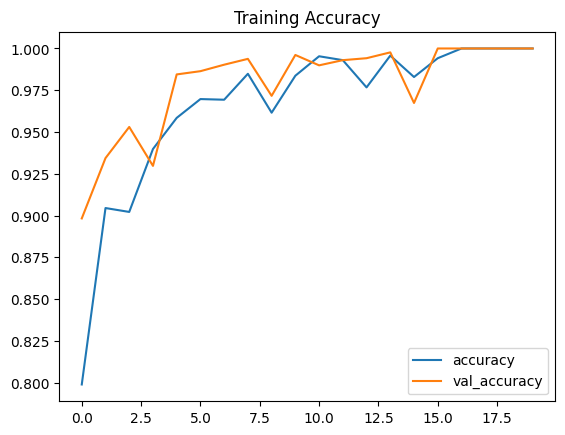

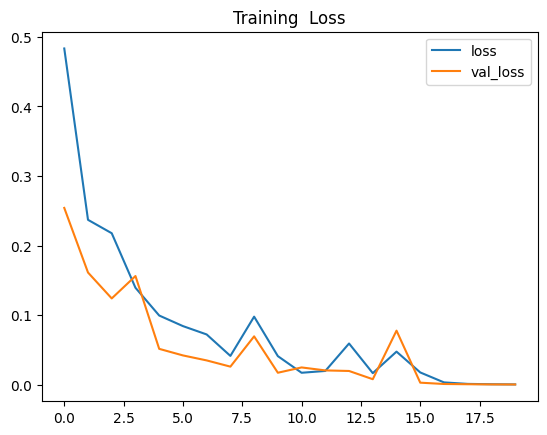



Accuracy on the test set: 97.91%
9/9 [==============================] - 5s 268ms/step
Accuracy: 0.97909
Precision: 0.97909
Recall: 0.97909
F1 Score: 0.97909
              precision    recall  f1-score   support

      Cancer       0.97      0.97      0.97        95
   NonCancer       0.98      0.98      0.98       192

    accuracy                           0.98       287
   macro avg       0.98      0.98      0.98       287
weighted avg       0.98      0.98      0.98       287

InceptionResNetV2 Confusion Matrix: 




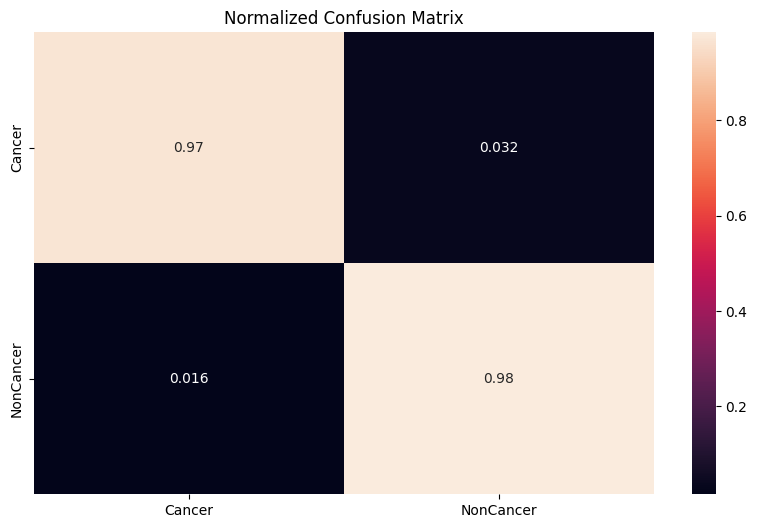

Performance: 

Rec=    97.63980263157895
Spe=    99.99174756164888
Pre=    97.6519314031816
FPR=    0.008252438351122578
FNR=    2.360197368421052
NPV=    99.99174771721053
FDR=    2.3480685968183983




9406464/9406464 [==============================] - 0s 0us/step
MobileNetV2 Model Training Started ===>>>
Epoch 1/20
81/81 [==============================] - 31s 336ms/step - loss: 0.2645 - accuracy: 0.8983 - val_loss: 0.1488 - val_accuracy: 0.9550
Epoch 2/20
81/81 [==============================] - 26s 323ms/step - loss: 0.0903 - accuracy: 0.9689 - val_loss: 0.0306 - val_accuracy: 0.9957
Epoch 3/20
81/81 [==============================] - 25s 316ms/step - loss: 0.0348 - accuracy: 0.9883 - val_loss: 0.0165 - val_accuracy: 0.9973
Epoch 4/20
81/81 [==============================] - 26s 320ms/step - loss: 0.0221 - accuracy: 0.9942 - val_loss: 0.0046 - val_accuracy: 0.9996
Epoch 5/20
81/81 [==============================] - 26s 323ms/step - loss: 0.0074 - accuracy: 0.9973 - val_loss: 0.0110

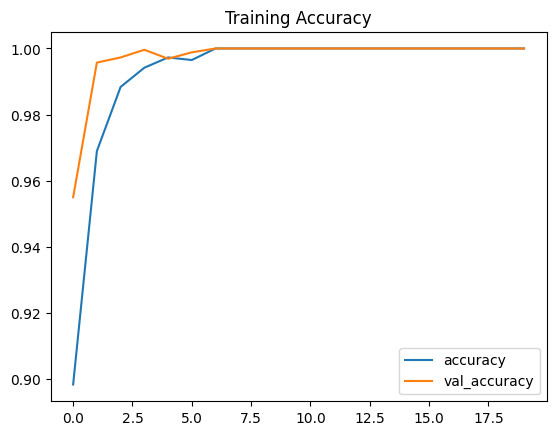

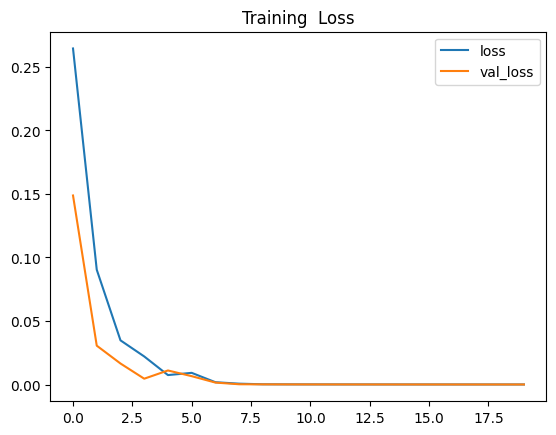



Accuracy on the test set: 98.26%
9/9 [==============================] - 2s 148ms/step
Accuracy: 0.98258
Precision: 0.98265
Recall: 0.98258
F1 Score: 0.9826
              precision    recall  f1-score   support

      Cancer       0.97      0.98      0.97        95
   NonCancer       0.99      0.98      0.99       192

    accuracy                           0.98       287
   macro avg       0.98      0.98      0.98       287
weighted avg       0.98      0.98      0.98       287

MobileNetV2 Confusion Matrix: 




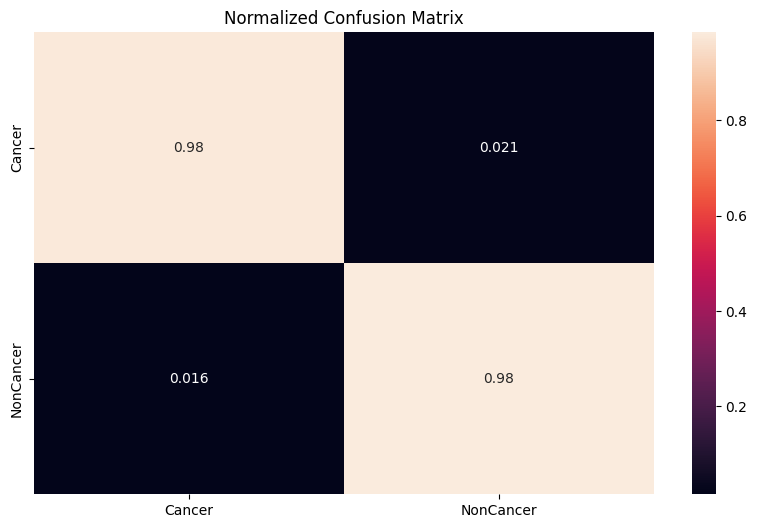

Performance: 

Rec=    98.16611842105263
Spe=    99.99358782664704
Pre=    98.16753739742646
FPR=    0.006412173352962839
FNR=    1.8338815789473661
NPV=    99.99358784465244
FDR=    1.8324626025735349




In [ ]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Dictionary with the models
models = {
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')
print('\n')

# Fit the models
for name, model in models.items():
    print('\n')

    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m


    print(f"{name:2} Model Training Started ===>>>")


    start = perf_counter()

    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=20,verbose=1)

    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:2} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

    results = m.evaluate(test_images, verbose=0)
    res=results[1]
    models[name]['test_accuracy'] = [round(res,4)]

    #ploting training acc loss
    print(f"{name:2} Train Accuracy and Loss Plot: \n")

    pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
    plt.title("Training Accuracy")
    plt.show()
    pd.DataFrame(history.history)[['loss','val_loss']].plot()
    plt.title("Training  Loss")
    plt.show()

    print("\n\nAccuracy on the test set: {:.2f}%".format(results[1] * 100))


    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    pred = m.predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    y_test = list(test_df.Label)

    print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
    print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
    print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
    print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
    print(classification_report(y_test, pred))


    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    import math
    from numpy import mean


    print(f"{name:2} Confusion Matrix: \n\n")
    cf_matrix = confusion_matrix(y_test, pred, normalize='true')
    plt.figure(figsize = (10,6))
    sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
    plt.title('Normalized Confusion Matrix')
    plt.show()

    confusion_matrix=cf_matrix

    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = len(y_test) - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    print("Performance: \n")
    print("Rec=   ",mean(TPR)*100)
    print("Spe=   ",mean(TNR)*100)
    print("Pre=   ",mean(PPV)*100)
    print("FPR=   ",mean(FPR)*100)
    print("FNR=   ",mean(FNR)*100)
    print("NPV=   ",mean(NPV)*100)
    print("FDR=   ",mean(FDR)*100)
    print("\n")

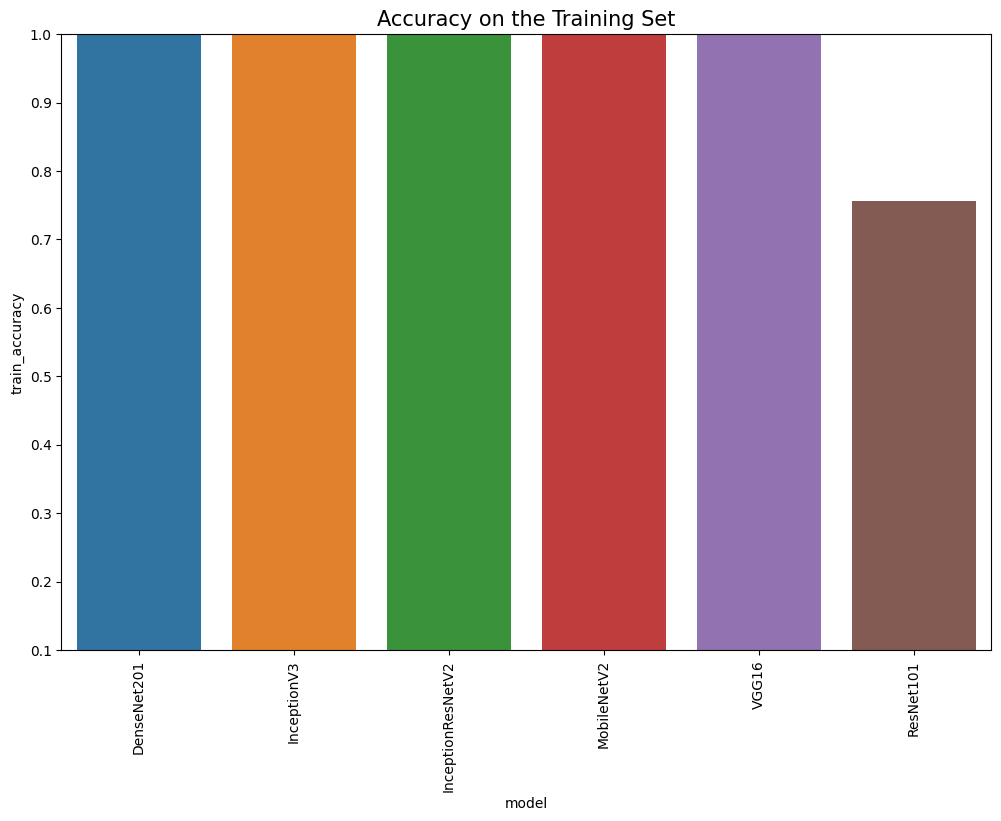

In [ ]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name,
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results
plt.figure(figsize = (12,8))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
plt.title('Accuracy on the Training Set', fontsize = 15)
plt.ylim(0.1,1)
plt.xticks(rotation=90)
plt.show()